# Trabalho 3 - Aprendizado por Reforço
## Treinamento de Agente no Ambiente CarRacing-v3

**Disciplina:** Inteligência Artificial - 2025/2  
**Professor:** Sérgio Nery Simões  
**Instituição:** IFES - Instituto Federal do Espírito Santo

---

### Objetivo
Treinar um agente utilizando PPO (Proximal Policy Optimization) para solucionar o ambiente CarRacing-v3 em três configurações: 250K, 500K e 750K timesteps.

## 1. Instalação de Dependências

Execute o seguinte comando no terminal Ubuntu:
```bash
pip install gymnasium[box2d] stable-baselines3[extra] tensorboard imageio imageio-ffmpeg matplotlib seaborn pandas
```

In [1]:
# Importações necessárias
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor
import os
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Configuração Inicial

In [2]:
# Configurações globais
TRAINING_CONFIGS = [250_000, 500_000, 750_000]  # Timesteps
MODEL_DIR = "modelos_salvos"
VIDEO_DIR = "videos_agentes"
LOG_DIR = "logs"

# Criar diretórios
for directory in [MODEL_DIR, VIDEO_DIR, LOG_DIR]:
    os.makedirs(directory, exist_ok=True)
    print(f"Diretório criado/verificado: {directory}")

# Verificar se o ambiente está disponível
try:
    test_env = gym.make('CarRacing-v3')
    test_env.close()
    print("\nAmbiente CarRacing-v3 disponível e funcionando!")
except Exception as e:
    print(f"\nErro ao carregar ambiente: {e}")

Diretório criado/verificado: modelos_salvos
Diretório criado/verificado: videos_agentes
Diretório criado/verificado: logs

Ambiente CarRacing-v3 disponível e funcionando!


## 3. Funções Auxiliares

In [3]:
def create_env():
    """Cria e configura o ambiente CarRacing-v3"""
    env = gym.make('CarRacing-v3', render_mode='rgb_array', continuous=True)
    env = Monitor(env)
    return env


def train_agent(total_timesteps, run_name):
    """
    Treina o agente PPO
    
    Args:
        total_timesteps: Número total de passos de treinamento
        run_name: Nome para salvar o modelo
    
    Returns:
        Caminho do modelo salvo
    """
    print(f"\n{'='*60}")
    print(f"Iniciando treinamento: {run_name}")
    print(f"Timesteps: {total_timesteps:,}")
    print(f"{'='*60}\n")
    
    # Criar ambiente
    env = DummyVecEnv([create_env])
    
    # Configuração do modelo PPO
    model = PPO(
        "CnnPolicy",
        env,
        learning_rate=1e-4,
        n_steps=1024,
        batch_size=64,
        n_epochs=5,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.1,
        ent_coef=0.003,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=0,
        tensorboard_log=f"{LOG_DIR}/{run_name}"
    )
    
    # Callback para salvar checkpoints
    checkpoint_callback = CheckpointCallback(
        save_freq=50_000,
        save_path=f"{MODEL_DIR}/{run_name}_checkpoints",
        name_prefix="ppo_carracing"
    )
    
    # Treinar
    start_time = datetime.now()
    model.learn(
        total_timesteps=total_timesteps,
        callback=checkpoint_callback,
        progress_bar=True
    )
    end_time = datetime.now()
    
    # Salvar modelo final
    model_path = f"{MODEL_DIR}/ppo_carracing_{run_name}.zip"
    model.save(model_path)
    
    training_time = (end_time - start_time).total_seconds() / 60
    print(f"\nTreinamento concluído em {training_time:.2f} minutos")
    print(f"Modelo salvo em: {model_path}\n")
    
    env.close()
    return model_path


def evaluate_agent(model_path, num_episodes=5):
    """
    Avalia o agente treinado
    
    Args:
        model_path: Caminho do modelo salvo
        num_episodes: Número de episódios para avaliação
    
    Returns:
        Lista de recompensas totais
    """
    print(f"Avaliando modelo: {model_path}")
    
    env = gym.make('CarRacing-v3', render_mode='rgb_array', continuous=True)
    model = PPO.load(model_path)
    
    episode_rewards = []
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        total_reward = 0
        done = False
        truncated = False
        steps = 0
        
        while not (done or truncated):
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            steps += 1
        
        episode_rewards.append(total_reward)
        print(f"  Episódio {episode+1}: Recompensa = {total_reward:.2f}, Passos = {steps}")
    
    env.close()
    
    avg_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    print(f"\n✓ Recompensa Média: {avg_reward:.2f} ± {std_reward:.2f}\n")
    
    return episode_rewards


def generate_video(model_path, video_name, max_steps=1000):
    """
    Gera vídeo do agente em ação
    
    Args:
        model_path: Caminho do modelo salvo
        video_name: Nome do arquivo de vídeo
        max_steps: Máximo de passos a gravar
    
    Returns:
        Caminho do vídeo e recompensa total
    """
    print(f"Gerando vídeo: {video_name}")
    
    env = gym.make('CarRacing-v3', render_mode='rgb_array', continuous=True)
    model = PPO.load(model_path)
    
    frames = []
    obs, info = env.reset()
    total_reward = 0
    
    for step in range(max_steps):
        frame = env.render()
        frames.append(frame)
        
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        
        if done or truncated:
            break
    
    env.close()
    
    # Salvar vídeo
    video_path = f"{VIDEO_DIR}/{video_name}"
    imageio.mimsave(video_path, frames, fps=30)
    
    print(f"Vídeo salvo: {video_path}")
    print(f"  Recompensa total: {total_reward:.2f}")
    print(f"  Frames gravados: {len(frames)}\n")
    
    return video_path, total_reward


print("Funções auxiliares definidas com sucesso!")

Funções auxiliares definidas com sucesso!


## 4. Treinamento dos Modelos

Tempos estimados (com GPU):
- 250K passos: ~45-60 minutos
- 500K passos: ~90-120 minutos  
- 750K passos: ~135-180 minutos

**Total estimado: 4-6 horas**

In [4]:
# Dicionário para armazenar resultados
results = {}

print("\n" + "="*60)
print("INICIANDO PIPELINE COMPLETO DE TREINAMENTO")
print("="*60 + "\n")

# Loop através das configurações
for timesteps in TRAINING_CONFIGS:
    run_name = f"{timesteps//1000}K"
    
    # 1. Treinar
    model_path = train_agent(timesteps, run_name)
    
    # 2. Avaliar
    rewards = evaluate_agent(model_path, num_episodes=5)
    
    # 3. Gerar vídeo
    video_path, video_reward = generate_video(
        model_path, 
        f"{run_name}_passos.mp4",
        max_steps=1000
    )
    
    # Armazenar resultados
    results[run_name] = {
        'model_path': model_path,
        'video_path': video_path,
        'eval_rewards': rewards,
        'video_reward': video_reward,
        'avg_reward': np.mean(rewards),
        'std_reward': np.std(rewards)
    }
    
    print(f"{'='*60}\n")

print("\nTREINAMENTO COMPLETO!\n")


INICIANDO PIPELINE COMPLETO DE TREINAMENTO


Iniciando treinamento: 250K
Timesteps: 250,000



Output()

## 5. Visualização dos Resultados

In [5]:
# Resumo textual
print("\n" + "="*60)
print("RESUMO DOS RESULTADOS")
print("="*60 + "\n")

for config, data in results.items():
    print(f"{config} passos:")
    print(f"  Recompensa média: {data['avg_reward']:.2f} ± {data['std_reward']:.2f}")
    print(f"  Recompensa no vídeo: {data['video_reward']:.2f}")
    print(f"  Modelo: {data['model_path']}")
    print(f"  Vídeo: {data['video_path']}")
    print()

print("="*60 + "\n")


RESUMO DOS RESULTADOS

250K passos:
  Recompensa média: -3.61 ± 7.77
  Recompensa no vídeo: -15.66
  Modelo: modelos_salvos/ppo_carracing_250K.zip
  Vídeo: videos_agentes/250K_passos.mp4

500K passos:
  Recompensa média: 55.33 ± 75.19
  Recompensa no vídeo: -2.44
  Modelo: modelos_salvos/ppo_carracing_500K.zip
  Vídeo: videos_agentes/500K_passos.mp4

750K passos:
  Recompensa média: 875.64 ± 35.23
  Recompensa no vídeo: 890.26
  Modelo: modelos_salvos/ppo_carracing_750K.zip
  Vídeo: videos_agentes/750K_passos.mp4




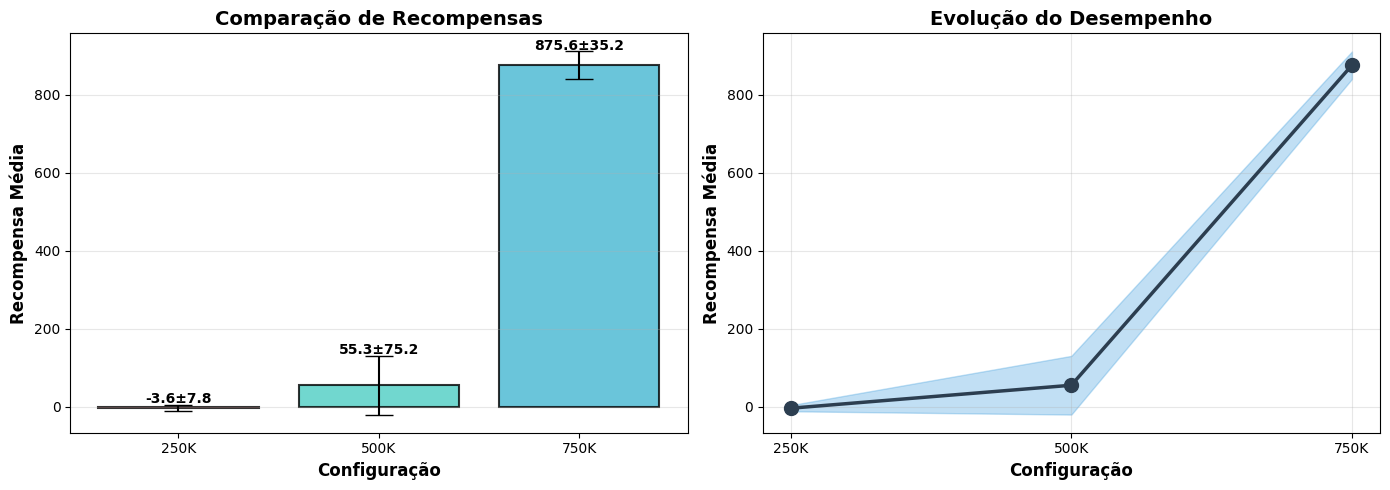

Gráfico salvo: comparison_plot.png


In [6]:
# Gráfico de comparação
configs = []
means = []
stds = []

for config, data in sorted(results.items()):
    configs.append(config)
    means.append(data['avg_reward'])
    stds.append(data['std_reward'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
x_pos = np.arange(len(configs))
ax1.bar(x_pos, means, yerr=stds, capsize=10,
        color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
        edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_xlabel('Configuração', fontsize=12, fontweight='bold')
ax1.set_ylabel('Recompensa Média', fontsize=12, fontweight='bold')
ax1.set_title('Comparação de Recompensas', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(configs)
ax1.grid(axis='y', alpha=0.3)

for i, (mean, std) in enumerate(zip(means, stds)):
    ax1.text(i, mean + std + 5, f'{mean:.1f}±{std:.1f}',
            ha='center', fontsize=10, fontweight='bold')

# Gráfico de linha
ax2.plot(configs, means, marker='o', linewidth=2.5,
        markersize=10, color='#2C3E50')
ax2.fill_between(range(len(configs)),
                 [m - s for m, s in zip(means, stds)],
                 [m + s for m, s in zip(means, stds)],
                 alpha=0.3, color='#3498DB')
ax2.set_xlabel('Configuração', fontsize=12, fontweight='bold')
ax2.set_ylabel('Recompensa Média', fontsize=12, fontweight='bold')
ax2.set_title('Evolução do Desempenho', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(configs)))
ax2.set_xticklabels(configs)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico salvo: comparison_plot.png")

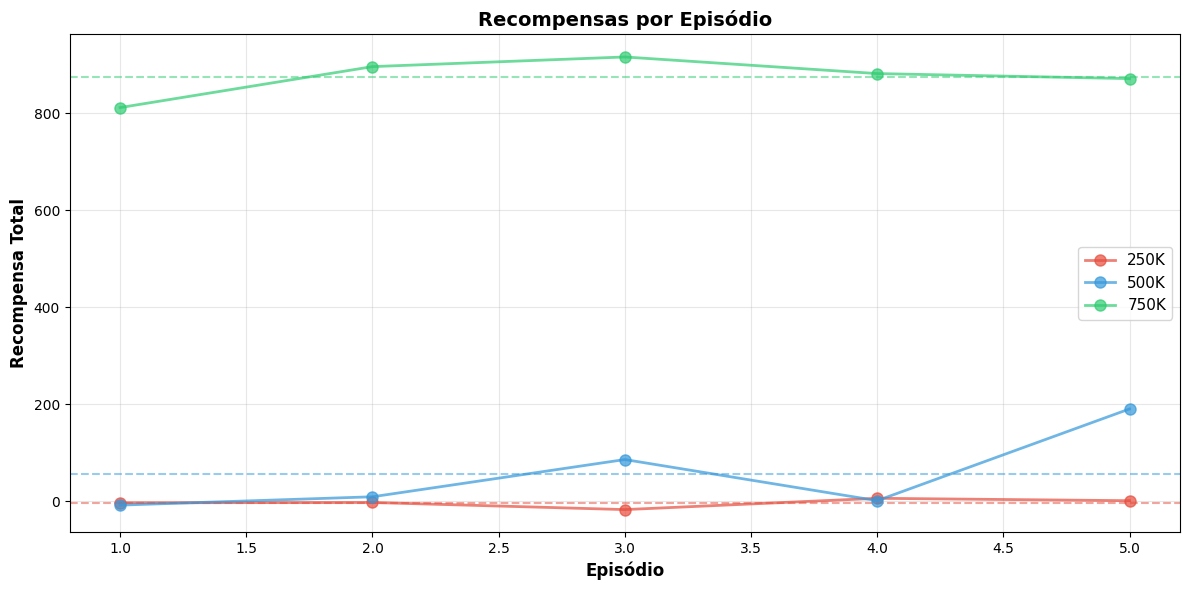

Gráfico salvo: episode_rewards.png


In [7]:
# Gráfico de recompensas por episódio
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#E74C3C', '#3498DB', '#2ECC71']

for idx, (config, data) in enumerate(sorted(results.items())):
    rewards = data['eval_rewards']
    episodes = range(1, len(rewards) + 1)
    
    ax.plot(episodes, rewards, marker='o', linewidth=2,
           markersize=8, label=config, color=colors[idx], alpha=0.7)
    
    ax.axhline(y=data['avg_reward'], color=colors[idx],
              linestyle='--', linewidth=1.5, alpha=0.5)

ax.set_xlabel('Episódio', fontsize=12, fontweight='bold')
ax.set_ylabel('Recompensa Total', fontsize=12, fontweight='bold')
ax.set_title('Recompensas por Episódio', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('episode_rewards.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico salvo: episode_rewards.png")

## 6. Análise de Melhoria

In [8]:
configs = sorted(results.keys())

print("\n" + "="*60)
print("ANÁLISE DE MELHORIA ENTRE CONFIGURAÇÕES")
print("="*60 + "\n")

for i in range(len(configs) - 1):
    current = configs[i]
    next_config = configs[i + 1]
    
    current_reward = results[current]['avg_reward']
    next_reward = results[next_config]['avg_reward']
    
    improvement = ((next_reward - current_reward) / abs(current_reward)) * 100
    
    print(f"{current} → {next_config}:")
    print(f"  Recompensa: {current_reward:.2f} → {next_reward:.2f}")
    print(f"  Melhoria: {improvement:+.2f}%")
    print(f"  Ganho absoluto: {next_reward - current_reward:+.2f}\n")

# Melhoria total
first_reward = results[configs[0]]['avg_reward']
last_reward = results[configs[-1]]['avg_reward']
total_improvement = ((last_reward - first_reward) / abs(first_reward)) * 100

print(f"Melhoria Total ({configs[0]} → {configs[-1]}):")
print(f"  {total_improvement:+.2f}%")
print(f"  Ganho absoluto: {last_reward - first_reward:+.2f}")
print("="*60 + "\n")


ANÁLISE DE MELHORIA ENTRE CONFIGURAÇÕES

250K → 500K:
  Recompensa: -3.61 → 55.33
  Melhoria: +1633.32%
  Ganho absoluto: +58.94

500K → 750K:
  Recompensa: 55.33 → 875.64
  Melhoria: +1482.57%
  Ganho absoluto: +820.31

Melhoria Total (250K → 750K):
  +24365.96%
  Ganho absoluto: +879.25



## 7. Teste de um Modelo Específico (Opcional)

Use esta célula para testar interativamente um modelo específico:

In [9]:
# Selecione qual modelo testar
# MODEL_TO_TEST = "750K"  # Opções: "250K", "500K", "750K"

# if MODEL_TO_TEST in results:
#    print(f"\nTestando modelo: {MODEL_TO_TEST}")
#    model_path = results[MODEL_TO_TEST]['model_path']
#    
#    # Avaliar mais episódios
#    test_rewards = evaluate_agent(model_path, num_episodes=10)
    
#    print(f"\nRecompensas dos 10 episódios: {test_rewards}")
#    print(f"Média: {np.mean(test_rewards):.2f}")
#    print(f"Desvio: {np.std(test_rewards):.2f}")
# else:
#    print(f"Modelo {MODEL_TO_TEST} não encontrado!")

## 8. Conclusão

### Arquivos Gerados:

1. **Modelos:**
   - `modelos_salvos/ppo_carracing_250K.zip`
   - `modelos_salvos/ppo_carracing_500K.zip`
   - `modelos_salvos/ppo_carracing_750K.zip`

2. **Vídeos:**
   - `videos_agentes/carracing_250K.mp4`
   - `videos_agentes/carracing_500K.mp4`
   - `videos_agentes/carracing_750K.mp4`

3. **Gráficos:**
   - `comparison_plot.png`
   - `episode_rewards.png`

4. **Logs (para TensorBoard):**
   - `logs/`

### Para visualizar os logs no TensorBoard:
```bash
tensorboard --logdir=logs/
```
